In [25]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, plot_confusion_matrix

from numeric import get_numeric_df

In [2]:
original_fraud_df = pd.read_csv("..\\Dataset\\preprocessed_data\\fraud_oracle_preprocessed_drop.csv")
# Potentiall improvement - transform nominal ordered attributes to a numeric ordinal variable

def transform_fraud(original_fraud_df: pd.DataFrame) -> tuple[pd.DataFrame, np.array, PCA]:
    numeric_fraud_df = get_numeric_df(original_fraud_df)
    labels = numeric_fraud_df.FraudFound_P.to_numpy()
    numeric_unlabelled_fraud_df = numeric_fraud_df.drop("FraudFound_P", axis=1)
    normalized_fraud_df = (numeric_unlabelled_fraud_df - numeric_unlabelled_fraud_df.mean())/numeric_unlabelled_fraud_df.std()
    normalized_fraud_df = StandardScaler().fit_transform(numeric_unlabelled_fraud_df)
    pca = PCA(.95)
    pca.fit(normalized_fraud_df)
    transformed_fraud_df = pca.transform(normalized_fraud_df)
    return transformed_fraud_df, labels, pca


def train_test(classifier, train_x, train_y, test_x, test_y, verbose=False):
    classifier.fit(train_x, train_y)

    y_pred = classifier.predict(test_x)
    if verbose:
        print(confusion_matrix(test_y, y_pred))
        print(classification_report(test_y, y_pred))
    return y_pred

In [3]:
U_COEFFICIENT = 0.125
O_COEFFICIENT = 10

transformed_fraud_df, labels, pca = transform_fraud(original_fraud_df)
X_train, X_test, y_train, y_test = train_test_split(transformed_fraud_df, labels, test_size=0.2, random_state=42)

positive = X_train[y_train == 1]
negative = X_train[y_train == 0]

neg_size = int(negative.shape[0]*U_COEFFICIENT)
undersampled = np.concatenate((negative[:neg_size], positive), axis=0)
undersampled_labels = np.concatenate(
    (
        np.zeros(shape=(neg_size,), dtype=np.int64),
        np.ones(shape=(positive.shape[0],), dtype=np.int64)
    )
)

pos_size = int(positive.shape[0]*O_COEFFICIENT)
oversampled = np.concatenate((negative, np.repeat(positive, O_COEFFICIENT, axis=0)), axis=0)
oversampled_labels = np.concatenate(
    (
        np.zeros(shape=(negative.shape[0],), dtype=np.int64),
        np.ones(shape=(pos_size,), dtype=np.int64)
    )
)

## Gather data from train-test sessions over enlarged, shrunk and base training sets

In [4]:
def save_scores(predicted: np.array, actual: np.array, f1_scores: list, accuracy: list) -> None:
    f1_scores.append(f1_score(actual, predicted))
    accuracy.append(accuracy_score(actual, predicted))

under = (undersampled, undersampled_labels)
over = (oversampled, oversampled_labels)
base = (X_train, y_train)
test = (X_test, y_test)

In [5]:
shallow_metrics = {
    "f1": dict(
        base = [],
        under = [],
        over = []
    ),
    "accuracy": dict(
        base = [],
        under = [],
        over = []
    )
}

sizes = (2, 4, 8, 16, 32, 64, 128, 256, 512)
for hidden_layer_size in sizes:
    classifier = MLPClassifier(hidden_layer_sizes=(hidden_layer_size, ), alpha=1, max_iter=10_000, random_state=42)
    for train_set, f1, acc in zip((base, under, over), shallow_metrics["f1"].values(), shallow_metrics["accuracy"].values()):
        predicted = train_test(classifier, *train_set, *test)
        save_scores(predicted, y_test, f1, acc)


### Comparison of F1 score of the FraudFound_P = 1 class over three training sets

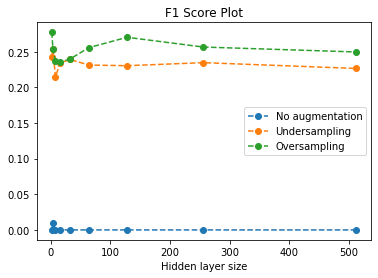

In [8]:
for f1, lab in zip(shallow_metrics["f1"].values(), ("No augmentation", "Undersampling", "Oversampling")):
    plt.plot(sizes, f1, label=lab, linestyle="--", marker='o')
plt.title("F1 Score Plot")
plt.legend()
plt.xlabel("Hidden layer size")
plt.show()

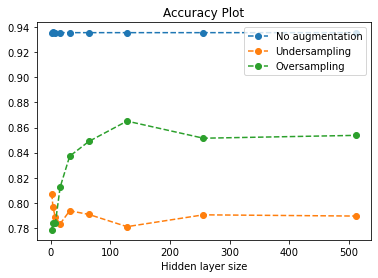

In [9]:
for acc, lab in zip(shallow_metrics["accuracy"].values(), ("No augmentation", "Undersampling", "Oversampling")):
    plt.plot(sizes, acc, label=lab, linestyle="--", marker='o')
plt.title("Accuracy Plot")
plt.xlabel("Hidden layer size")
plt.legend()
plt.show()

## Similar comparison for deeper network

In [10]:
deep_metrics = {
    "f1": dict(
        base = [],
        under = [],
        over = []
    ),
    "accuracy": dict(
        base = [],
        under = [],
        over = []
    )
}
sizes = (2, 4, 8, 16, 32, 64, 128, 256, 512)
for hidden_layer_size in sizes:
    classifier = MLPClassifier(hidden_layer_sizes=(64, hidden_layer_size, 64), alpha=1, max_iter=10_000, random_state=42)
    for train_set, f1, acc in zip((base, under, over), deep_metrics["f1"].values(), deep_metrics["accuracy"].values()):
        predicted = train_test(classifier, *train_set, *test)
        save_scores(predicted, y_test, f1, acc)


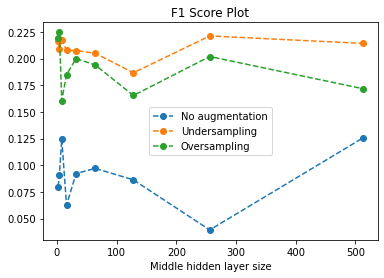

In [11]:
for f1, lab in zip(deep_metrics["f1"].values(), ("No augmentation", "Undersampling", "Oversampling")):
    plt.plot(sizes, f1, label=lab, linestyle="--", marker='o')
plt.title("F1 Score Plot")
plt.xlabel("Middle hidden layer size")
plt.legend()
plt.show()

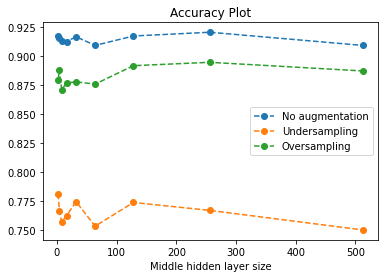

In [12]:
for acc, lab in zip(deep_metrics["accuracy"].values(), ("No augmentation", "Undersampling", "Oversampling")):
    plt.plot(sizes, acc, label=lab, linestyle="--", marker='o')
plt.title("Accuracy Plot")
plt.xlabel("Middle hidden layer size")
plt.legend()
plt.show()

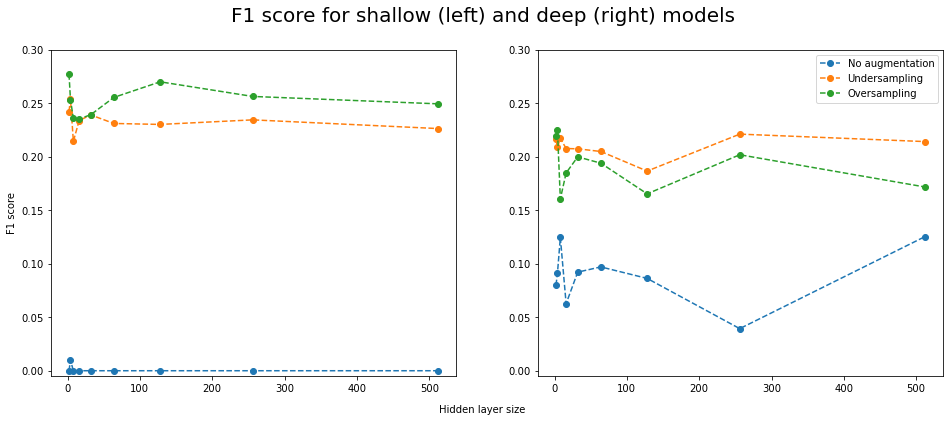

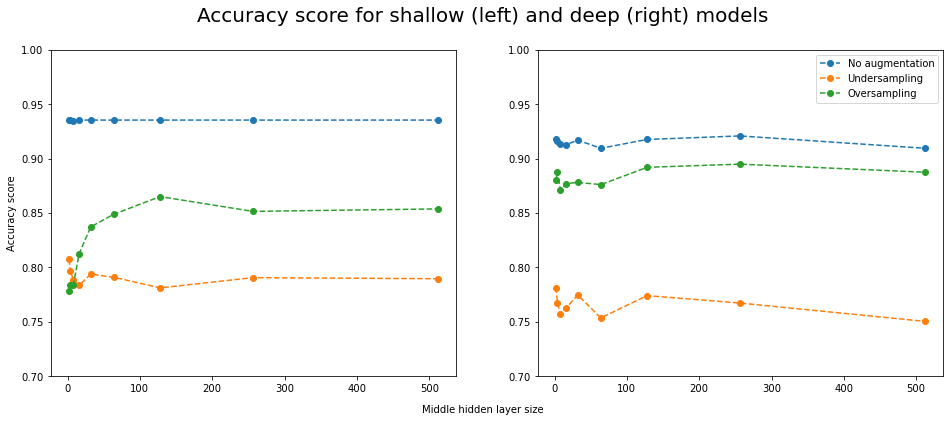

In [16]:
fig, subplots = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("F1 score for shallow (left) and deep (right) models", fontsize=20)
for f1, lab in zip(shallow_metrics["f1"].values(), ("No augmentation", "Undersampling", "Oversampling")):
    subplots[0].plot(sizes, f1, label=lab, linestyle="--", marker='o')
for acc, lab in zip(deep_metrics["f1"].values(), ("No augmentation", "Undersampling", "Oversampling")):
    subplots[1].plot(sizes, acc, label=lab, linestyle="--", marker='o')
subplots[0].set_ylabel("F1 score") 
subplots[0].set_ylim([-0.005, 0.3])
subplots[1].set_ylim([-0.005, 0.3])
fig.text(0.5, 0.04, 'Hidden layer size', ha='center')

plt.legend(loc="best")

plt.savefig("f1.png")

fig, subplots = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Accuracy score for shallow (left) and deep (right) models", fontsize=20)

for f1, lab in zip(shallow_metrics["accuracy"].values(), ("No augmentation", "Undersampling", "Oversampling")):
    subplots[0].plot(sizes, f1, label=lab, linestyle="--", marker='o') 
for acc, lab in zip(deep_metrics["accuracy"].values(), ("No augmentation", "Undersampling", "Oversampling")):
    subplots[1].plot(sizes, acc, label=lab, linestyle="--", marker='o')
subplots[0].set_ylabel("Accuracy score")
subplots[0].set_ylim([0.7, 1])
subplots[1].set_ylim([0.7, 1])
fig.text(0.5, 0.04, 'Middle hidden layer size', ha='center')
plt.legend(loc="best")

plt.savefig("acc.png")

## Data Generation

In [12]:
import torch
import deep_tabular_augmentation as dta
from torch import nn
from torch import optim
from functools import partial

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train, X_test, y_train, y_test = train_test_split(transformed_fraud_df, labels, test_size=0.2, random_state=42)

x_scaler = StandardScaler()

X_train_scaled = x_scaler.fit_transform(X_train)

X_test_scaled = x_scaler.transform(X_test)

positive_train = X_train_scaled[y_train == 1]

positive_test = X_test_scaled[y_test == 1]

datasets = dta.create_datasets_no_target_var(positive_train, positive_test)
data = dta.DataBunch(*dta.create_loaders(datasets, bs=1024))

In [22]:
D_in = X_test_scaled.shape[1]
VAE_arch = [50, 12, 12]
df_cols = [f"PCA_{i}" for i in range(D_in)]

model = dta.Autoencoder(D_in, VAE_arch, latent_dim=5).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
loss_func = dta.customLoss()

In [23]:
learn = dta.Learner(model, opt, loss_func, data, cols=df_cols)

run = dta.Runner(cb_funcs=[dta.LR_Find, dta.Recorder])

run.fit(100, learn)

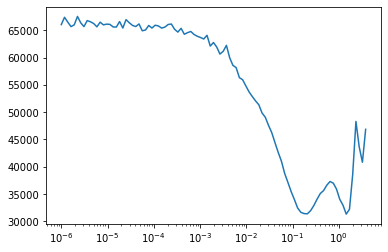

In [24]:
run.recorder.plot(skip_last=5)

In [25]:
sched = dta.combine_scheds([0.3, 0.7], [dta.sched_cos(0.01, 0.1), dta.sched_cos(0.1, 0.01)])

In [26]:
cbfs = [partial(dta.LossTracker, show_every=100), dta.Recorder, partial(dta.ParamScheduler, 'lr', sched)]
model = dta.Autoencoder(D_in, VAE_arch, latent_dim=20).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
learn = dta.Learner(model, opt, loss_func, data, cols=df_cols)
run = dta.Runner(cb_funcs=cbfs)
run.fit(1_000, learn)

epoch: 100
train loss is: 77043.1875
validation loss is: 7708.72412109375
epoch: 200
train loss is: 32132.275390625
validation loss is: 7095.138671875
epoch: 300
train loss is: 26737.4921875
validation loss is: 6631.1181640625
epoch: 400
train loss is: 24369.12109375
validation loss is: 6419.8623046875
epoch: 500
train loss is: 22961.576171875
validation loss is: 6307.8291015625
epoch: 600
train loss is: 21970.654296875
validation loss is: 6267.8603515625
epoch: 700
train loss is: 21131.33203125
validation loss is: 6150.0576171875
epoch: 800
train loss is: 20497.91796875
validation loss is: 6130.64697265625
epoch: 900
train loss is: 19985.333984375
validation loss is: 6110.5283203125
epoch: 1000
train loss is: 19582.177734375
validation loss is: 6166.79296875
epoch: 1100
train loss is: 19238.875
validation loss is: 6142.1259765625
epoch: 1200
train loss is: 19089.66796875
validation loss is: 6517.30859375
epoch: 1300
train loss is: 18842.375
validation loss is: 6439.33154296875
epoch: 

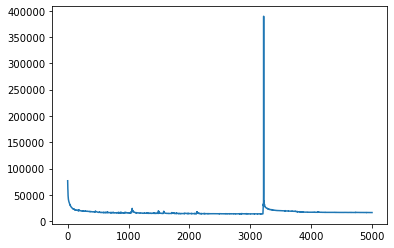

In [27]:
run.recorder.plot_loss()

In [28]:
new_records = 3000
df_fake = run.predict_df(learn, no_samples=new_records, scaler=x_scaler)
df_fake_with_noise = run.predict_with_noise_df(learn, no_samples=new_records, mu=0, sigma=pd.DataFrame(positive_train, columns=df_cols).std()/10, scaler=x_scaler)

In [29]:
df_fake_with_noise.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,...,PCA_33,PCA_34,PCA_35,PCA_36,PCA_37,PCA_38,PCA_39,PCA_40,PCA_41,PCA_42
0,-0.872495,-0.814280,0.021286,-0.874830,0.056491,1.621146,-0.157026,0.333353,0.326314,0.647337,...,0.050546,-0.275759,-0.001404,-0.115055,0.129809,-0.714545,-0.118790,0.175011,0.113279,0.087295
1,-0.938837,-0.622043,0.006192,-0.312714,-0.175178,0.468499,-0.294924,0.113472,0.355385,0.464607,...,0.065634,-0.256768,-0.111330,-0.203737,0.221320,-0.897292,0.114810,0.057119,0.061959,0.013162
2,-0.872261,-0.704208,-0.088210,-0.647035,-0.072893,1.171419,-0.266301,0.068719,0.407551,0.597357,...,0.001747,-0.244290,-0.336675,-0.163709,0.031118,-0.722323,-0.390966,-0.037786,-0.024271,0.040492
3,-0.906327,-0.839722,-0.260353,-0.759664,-0.113872,1.509154,-0.222087,0.261060,0.422025,0.370220,...,0.067147,-0.420106,-0.269070,-0.157394,-0.011282,-0.802158,-0.058671,0.167327,-0.127537,0.272091
4,-0.884151,-0.671004,0.052527,-0.617522,0.017176,1.191034,-0.145745,0.161657,0.462222,0.772216,...,-0.072206,-0.378940,-0.414747,-0.072187,-0.133923,-0.802485,-0.009693,0.090298,-0.052638,0.169712


In [30]:
print(positive.mean(), df_fake_with_noise.to_numpy().mean())
print(negative.mean())
print(transformed_fraud_df.mean())

-0.022861781101415866 -0.060749051499762265
0.00018417247648175046
1.5475073948897007e-17


In [31]:
fake_positive = df_fake_with_noise.to_numpy()
augmented = np.concatenate((X_train, fake_positive), axis=0)
augmented_labels = np.concatenate((y_train, np.ones(shape=(fake_positive.shape[0], ), dtype=np.int64)))
aug = (augmented, augmented_labels)

augmented_2 = np.concatenate((undersampled, fake_positive), axis=0)
augmented_labels_2 = np.concatenate((undersampled_labels, np.ones(shape=(fake_positive.shape[0], ), dtype=np.int64)))
aug_2 = (augmented_2, augmented_labels_2)

In [32]:
shallow_dos_metrics = {
    "f1": dict(
        base = [],
        under = [],
        over = [],
        aug = []
    ),
    "accuracy": dict(
        base = [],
        under = [],
        over = [],
        aug = []
    )
}

sizes = (2, 4, 8, 16, 32, 64, 128, 256, 512)
for hidden_layer_size in sizes:
    classifier = MLPClassifier(hidden_layer_sizes=(hidden_layer_size, ), alpha=1, max_iter=10_000, random_state=42)
    for train_set, f1, acc in zip((base, under, over, aug), shallow_dos_metrics["f1"].values(), shallow_dos_metrics["accuracy"].values()):
        predicted = train_test(classifier, *train_set, *test)
        save_scores(predicted, y_test, f1, acc)

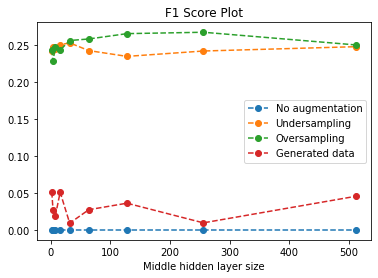

In [33]:
for f1, lab in zip(shallow_dos_metrics["f1"].values(), ("No augmentation", "Undersampling", "Oversampling", "Generated data")):
    plt.plot(sizes, f1, label=lab, linestyle="--", marker='o')
plt.title("F1 Score Plot")
plt.xlabel("Middle hidden layer size")
plt.legend()
plt.show()

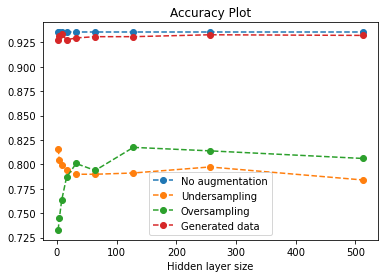

In [34]:
for acc, lab in zip(shallow_dos_metrics["accuracy"].values(), ("No augmentation", "Undersampling", "Oversampling", "Generated data")):
    plt.plot(sizes, acc, label=lab, linestyle="--", marker='o')
plt.title("Accuracy Plot")
plt.xlabel("Hidden layer size")
plt.legend()
plt.show()

In [35]:
classifier = MLPClassifier(hidden_layer_sizes=(128,), alpha=1, max_iter=10_000, random_state=42)
result = train_test(classifier, *over, *test, verbose=True)

[[2419  466]
 [  97  102]]
              precision    recall  f1-score   support

           0       0.96      0.84      0.90      2885
           1       0.18      0.51      0.27       199

    accuracy                           0.82      3084
   macro avg       0.57      0.68      0.58      3084
weighted avg       0.91      0.82      0.86      3084



d:\Programs\Anaconda\envs\dviz\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


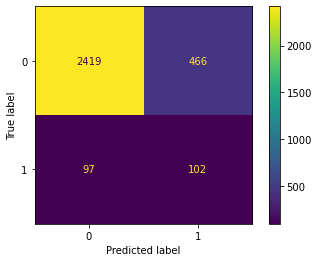

In [36]:
plot_confusion_matrix(classifier, X_test, y_test)

d:\Programs\Anaconda\envs\dviz\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


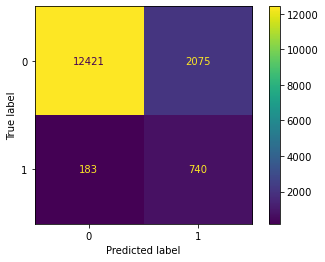

In [37]:
plot_confusion_matrix(classifier, transformed_fraud_df, labels)

In [26]:
classifier = MLPClassifier(hidden_layer_sizes=(128,), alpha=1, max_iter=10_000, random_state=42)
cv_p = cross_val_predict(classifier, oversampled, oversampled_labels, cv=5)

## Grid Search

In [22]:
params = [dict(
    hidden_layer_sizes=[(64,)]
)]

clf = MLPClassifier(max_iter=10_000)
gs = GridSearchCV(clf, param_grid=params, scoring="f1", cv=5, refit=False)
gs.fit(undersampled, undersampled_labels)   

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=10000),
             param_grid=[{'hidden_layer_sizes': [(64,)]}], refit=False,
             scoring='f1')

In [21]:
gs.best_params_

{'hidden_layer_sizes': (64,)}

In [23]:
plot_confusion_matrix(gs.estimator, transformed_fraud_df, labels)

d:\Programs\Anaconda\envs\dviz\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


NotFittedError: This MLPClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [14]:
gs.best_score_

0.5557679576517505